# Thickness Interpolation

More or less the same as [BedMachineToElmer](BedMachineToElmer.ipynb).

However here we interpolate the thichkness, which is not defined outside the icy mask, and thus the values are equal to the _FillValue attribute.

The boundary of the elmer grid might not exactly correspond to the ice mask; just check what's appening


In [1]:
import sys
import os
import xarray as xr
import xugrid as xu

from numba_celltree.celltree import(cast_vertices, cast_faces)
from scipy.sparse import *

sys.path.insert(0, os.path.abspath('../'))

from ElmerUgrid import ugrid
from ElmerUgrid.Interpolation import *
from ElmerUgrid.Projection import *
from ElmerUgrid.fem import TriIntegrate

# get BedMachine

In [2]:
bdm = xr.open_dataset("../DATA/BedMachineAntarctica_v02_m.nc")
## coarsen the data for faster testing
step=4
data=bdm.coarsen(x=step,y=step,boundary="trim").mean()

data.thickness.plot()

# Get Elmer

In [3]:
tmp=xu.open_dataset("../DATA/elmer_antarctica_000.nc",decode_times=False)
tmp.ugrid.set_crs("EPSG:4326")
ismip6_init=tmp.ugrid.to_crs("EPSG:3031")
elmer_grid=ismip6_init.bedrock.grid

In [4]:
## Plot data and elmer mesh
data.thickness.plot()
elmer_grid.plot(color="black",linewidth=0.1)

# Create a UgridDataArray from the input thickness 

In [5]:
data_ugrid=xu.UgridDataArray.from_structured(data.thickness)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
## selected only the cell grids where thickness is not nan
active_set=data_ugrid.isel(mesh2d_nFaces=(np.isfinite(data_ugrid.data)))
print(active_set)
active_set.ugrid.plot()

<xarray.DataArray 'thickness' (mesh2d_nFaces: 3408365)> Size: 14MB
array([2.463878 , 1.3121625, 0.8638131, ..., 1.       , 1.       ,
       1.       ], dtype=float32)
Coordinates:
  * mesh2d_nFaces  (mesh2d_nFaces) int64 27MB 0 1 2 ... 3408362 3408363 3408364


## First test regridding from the active set

there is 2418 nans


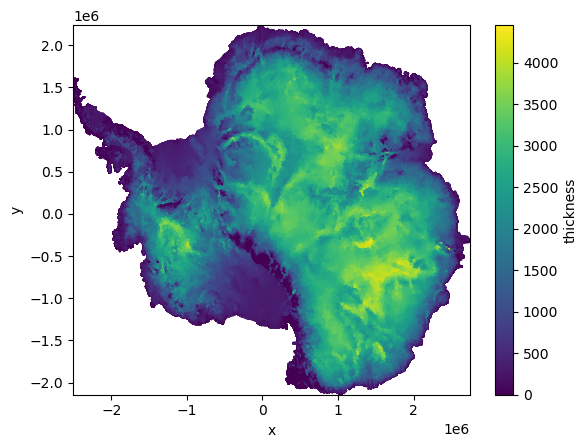

In [7]:
## assume that data are face_values
## results is a varaible defined on the elements
regridder = xu.OverlapRegridder(source=active_set, target=elmer_grid, method="mean")
result_mean = regridder.regrid(active_set)
result_mean.attrs=dict(mesh=elmer_grid.name,location="face") ## add the ugrid attributes for saving
result_mean.ugrid.plot()

## rq. cell that are not ovberlapped by the data are set to nan
nans = (np.isnan(result_mean.values)).sum()
print("there is %i nans"%nans)


## Test regridding from the full set

there is 2418 nans


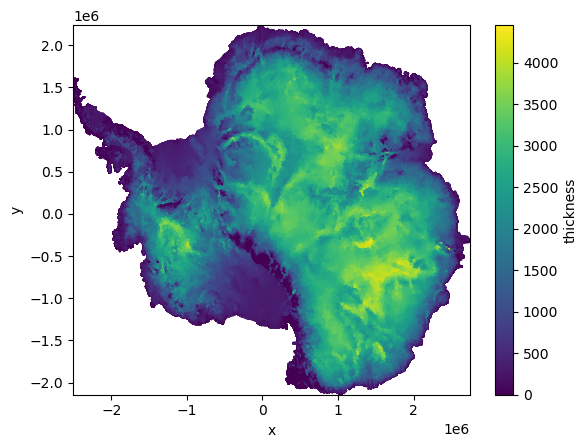

In [8]:
## assume that data are face_values
## results is a varaible defined on the elements
regridder = xu.OverlapRegridder(source=data_ugrid, target=elmer_grid, method="mean")
result_mean2 = regridder.regrid(data_ugrid)
result_mean2.attrs=dict(mesh=elmer_grid.name,location="face") ## add the ugrid attributes for saving
result_mean2.ugrid.plot()

## rq. cell that are ovberlapped by data with nan are nan
nans = (np.isnan(result_mean2.values)).sum()
print("there is %i nans"%nans)

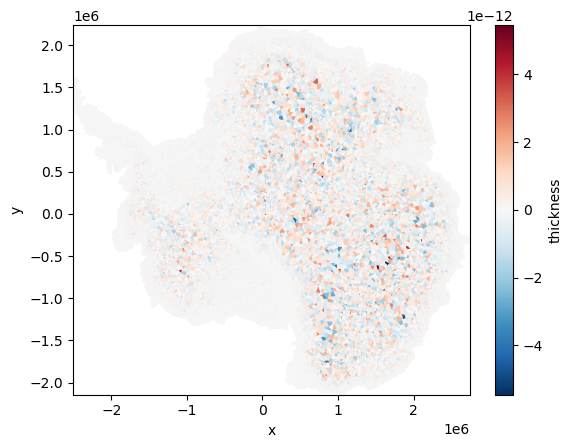

In [9]:
## results are the same
diff0=result_mean2-result_mean
diff0.ugrid.plot()

## Home made interpolation

we can get the intersection area

/tmp/ipykernel_665351/741122824.py:30: RuntimeWarning: invalid value encountered in divide
  bed_f_i=np.where(intersect_area > 0.0,bed_f_i/intersect_area,np.nan)


there is 2418 nans


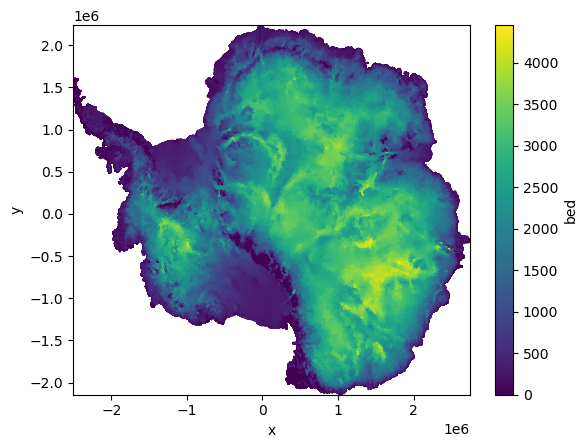

In [10]:
data_grid=active_set.grid

target_vertices=cast_vertices(elmer_grid.node_coordinates)
target_faces=cast_faces(elmer_grid.face_node_connectivity,elmer_grid.fill_value)

source_vertices=cast_vertices(data_grid.node_coordinates)
source_faces=cast_faces(data_grid.face_node_connectivity, data_grid.fill_value)

## Compute the intersection between source and target faces 
target_indices,source_indices=data_grid.celltree._locate_faces(target_vertices,target_faces)

## Conservative face to face interpolation weights for the gradient
weights_f,target_face_index_f,source_face_index_f=face_2_face_interpolation(
            vertices_a=target_vertices,
            vertices_b=source_vertices,
            faces_a=target_faces,
            faces_b=source_faces,
            indices_a=target_indices,
            indices_b=source_indices,
        )


Mf = coo_matrix((weights_f,(target_face_index_f,source_face_index_f)), shape=(elmer_grid.n_face,data_grid.n_face) )
Mf=Mf.tocsr()

face_ones=np.ones(data_grid.n_face,dtype=np.float64)
intersect_area=Mf*face_ones

bed_f_i=Mf*active_set.data
bed_f_i=np.where(intersect_area > 0.0,bed_f_i/intersect_area,np.nan)
#bed_f_i /= intersect_area

result_2 = xr.DataArray(
    data=bed_f_i,
    name="bed",
    dims=[elmer_grid.face_dimension],
    attrs=dict(mesh=elmer_grid.name,location="face"))
    
result_2 = xu.UgridDataArray(result_2, elmer_grid)
result_2.ugrid.plot()

## rq. cell that are not ovberlapped by the data are set to nan
nans = (np.isnan(result_2.values)).sum()
print("there is %i nans"%nans)

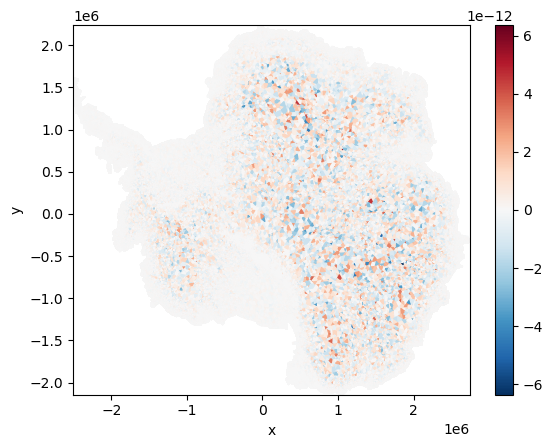

In [11]:
diff=result_mean-result_2
diff.ugrid.plot()


iarea_da = xu.UgridDataArray(
    xr.DataArray(
    data=intersect_area,
    name="area",
    dims=[elmer_grid.face_dimension],
    attrs=dict(mesh=elmer_grid.name,location="face")),
    elmer_grid)

area_da=  xu.UgridDataArray(
    xr.DataArray(
    data=elmer_grid.area,
    name="area",
    dims=[elmer_grid.face_dimension],
    attrs=dict(mesh=elmer_grid.name,location="face")),
    elmer_grid)
    



In [12]:
## project to nodes
## rq. cells with nan are skipped for the weighted avarage
face_values=result_mean.values
zero_values=np.zeros((elmer_grid.n_face,2))

result_n=face_2_node_projection(face_values=face_values,
                               grad_values=zero_values,
                               nn=elmer_grid.n_node,
                               faces=elmer_grid.face_node_connectivity,
                               facesx=elmer_grid.face_coordinates,
                               nodes=elmer_grid.face_node_coordinates

                            )
## nodes that are owned "only" by non overlapped cells are nan
nans = (np.isnan(result_n)).sum()
print("there is %i nans"%nans)

## we can apply a correction to the nodal nan values:
hmin=0.1
result_n=np.where((np.isfinite(result_n) & (result_n > hmin)),result_n,hmin)


res_da = xu.UgridDataArray(
            xr.DataArray(
                data=result_n,
                name="bed",
                dims=[elmer_grid.node_dimension],
                attrs=dict(mesh=elmer_grid.name,location="node")),elmer_grid)

there is 756 nans


/home/gilletcf/GitLab/elmerugrid/ElmerUgrid/Projection.py:55: RuntimeWarning: invalid value encountered in divide
  result = np.where(weight > 0.0,output / weight,np.nan)


In [13]:
ds=xu.UgridDataset(grids=elmer_grid)
ds["result_mean"]=result_mean
ds["result_2"]=result_2
ds["intersect_area"]=iarea_da
ds["area"]=area_da
ds["result_n"]=res_da

ds.ugrid.to_netcdf_forpv("ThicknessInterpolation.nc")

# Conclusion

the 3 interpolation methods give the same results;
Just be carefull that it return nans for elements that are only partially covered.

When doing the node projection, cells with nans are skipped for the weighted average; and only nodes belonging only to elements not overlapped are nan; so the correction can be done on the final nodal results;
But it could also be node for the face values, but will result in some smooothing for the nodal values.